In [1]:
import uproot
from glob import glob
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.analysis_tools import PackedSelection
import awkward as ak
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import mplhep



mplhep.style.use(mplhep.style.CMS)
#SWAN 
base_directory = "/eos/user/d/dgrove/datasets/"

files = sorted(glob(f"{base_directory}ttbar_nAODv12/data/*.root"))


file = uproot.open(files[0])
#events = NanoEventsFactory.from_root(files).events()

print("Number of TSlepSlep files: {0}".format(len(files)))
print("file info:")
dict(file)

Number of TSlepSlep files: 1
file info:


{'tag;1': <TObjString 'untagged' at 0x7f6117c1fcf0>,
 'Events;1': <TTree 'Events' (1782 branches) at 0x7f6117bc6580>,
 'LuminosityBlocks;1': <TTree 'LuminosityBlocks' (6 branches) at 0x7f6117bc6130>,
 'Runs;1': <TTree 'Runs' (10 branches) at 0x7f6117bc6910>,
 'MetaData;1': <TTree 'MetaData' (1 branches) at 0x7f6117bc6100>,
 'ParameterSets;1': <TTree 'ParameterSets' (1 branches) at 0x7f6117bc63d0>}

In [2]:
events = NanoEventsFactory.from_root(files[0]).events()
len(events)

468000

In [3]:
events.Electron.fields

['seediEtaOriX',
 'convVeto',
 'cutBased',
 'cutBased_HEEP',
 'isPFcand',
 'jetNDauCharged',
 'lostHits',
 'mvaIso_WP80',
 'mvaIso_WP90',
 'mvaNoIso_WP80',
 'mvaNoIso_WP90',
 'seedGain',
 'tightCharge',
 'jetIdx',
 'photonIdx',
 'svIdx',
 'fsrPhotonIdx',
 'charge',
 'pdgId',
 'seediPhiOriY',
 'vidNestedWPBitmap',
 'vidNestedWPBitmapHEEP',
 'deltaEtaSC',
 'dr03EcalRecHitSumEt',
 'dr03HcalDepth1TowerSumEt',
 'dr03TkSumPt',
 'dr03TkSumPtHEEP',
 'dxy',
 'dxyErr',
 'dz',
 'dzErr',
 'eInvMinusPInv',
 'energyErr',
 'eta',
 'hoe',
 'ip3d',
 'jetPtRelv2',
 'jetRelIso',
 'mass',
 'miniPFRelIso_all',
 'miniPFRelIso_chg',
 'mvaHZZIso',
 'mvaIso',
 'mvaNoIso',
 'pfRelIso03_all',
 'pfRelIso03_chg',
 'phi',
 'pt',
 'r9',
 'scEtOverPt',
 'sieie',
 'sip3d',
 'mvaTTH',
 'genPartFlav',
 'genPartIdx',
 'genPartIdxG',
 'jetIdxG',
 'photonIdxG']

In [11]:
selection = PackedSelection()

#first block
selection.add("e pt", ak.any(events.Electron.pt >= 5, axis=1))
selection.add("e eta", ak.any(np.abs(events.Electron.eta) < 2.4, axis=1))
selection.add("e SIP3D", ak.any(events.Electron.sip3d < 8, axis=1))
selection.add("e dxy", ak.any(np.abs(events.Electron.dxy) < 0.05, axis=1))
selection.add("e dz", ak.any(np.abs(events.Electron.dz) < 0.1, axis=1))
selection.add("e miniPFRelIso", ak.any(events.Electron.miniPFRelIso_all < (20 + 300/events.Electron.pt), axis =1))

selection.add("mu pt", ak.any(events.Muon.pt >= 3, axis=1))
selection.add("mu eta", ak.any(np.abs(events.Muon.eta) < 2.4, axis=1))
selection.add("mu SIP3D", ak.any(events.Muon.sip3d < 8, axis=1))
selection.add("mu dxy", ak.any(np.abs(events.Muon.dxy) < 0.05, axis=1))
selection.add("mu dz", ak.any(np.abs(events.Muon.dz) < 0.1, axis=1))
selection.add("mu miniPFRelIso", ak.any(events.Muon.miniPFRelIso_all < (20 + 300/events.Muon.pt), axis=1))

# individual cuts above, all in one selection cuts below:
# please use cuts below if doing preselection cut lest you run into some logical bugs down the road

#second block
selection.add("e selection", ak.any((events.Electron.pt >= 5) & (np.abs(events.Electron.eta) < 2.4) & (events.Electron.sip3d < 8) & (np.abs(events.Electron.dxy) < 0.05) & (np.abs(events.Electron.dz) < 0.1) & (events.Electron.miniPFRelIso_all < (20 + 300/events.Electron.pt)), axis=1))
selection.add("mu selection", ak.any((events.Muon.pt >= 5) & (np.abs(events.Muon.eta) < 2.4) & (events.Muon.sip3d < 8) & (np.abs(events.Muon.dxy) < 0.05) & (np.abs(events.Muon.dz) < 0.1) & (events.Muon.miniPFRelIso_all < (20 + 300/events.Muon.pt)), axis=1))

selection.add("electron flav1", ak.any(events.Electron.genPartFlav == 1, axis=1))
selection.add("electron flav0", ak.any(events.Electron.genPartFlav == 0, axis=1))

flav1events = events[selection.any("electron flav1")]
flav0events = events[selection.any("electron flav0")]
print(len(flav1events))
print(len(flav0events))

electrons = events.Electron

flav1_mask = (electrons.genPartFlav == 1)
flav0_mask = (electrons.genPartFlav == 0)

flav1_e = electrons[flav1_mask]
flav0_e = electrons[flav0_mask]

233456
148670


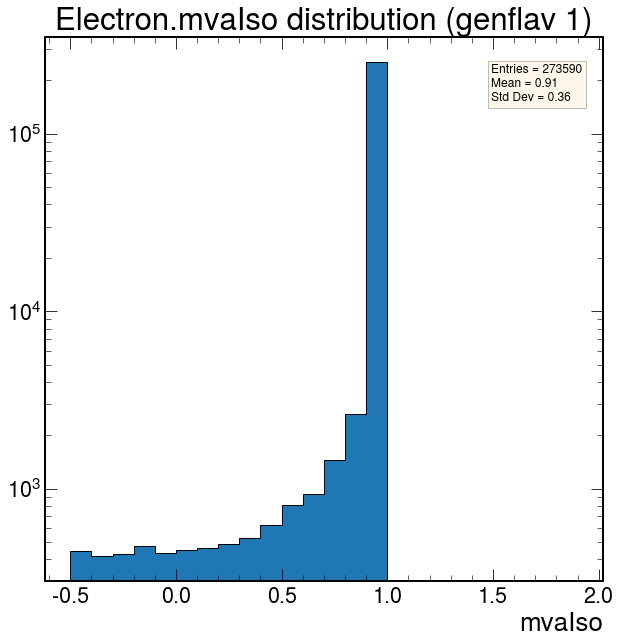

In [12]:
fig, ax = plt.subplots()
ax.set_xlabel("mvaIso")
ax.set_title("Electron.mvaIso distribution (genflav 1)")
ax.set_yscale('log')
flattened_mva = ak.flatten(flav1_e.mvaIso)

#_____________________________
#stats box to imitate root's:
mean = np.mean(flattened_mva)
std_dev = np.std(flattened_mva)
entries = len(flattened_mva)
stats_text = f"Entries = {entries}\nMean = {mean:.2f}\nStd Dev = {std_dev:.2f}"
props = dict(boxstyle='square', facecolor='wheat', alpha=0.25)
ax.text(0.80, 0.95, stats_text, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)
#end stats box code
#-----------------------------


bin_edges = np.arange(-0.5, 2, 0.1)

#ax.hist(filtered_counts, bins=np.linspace(0, 5, 6))  # bins from 1 to 4
ax.hist(flattened_mva, bins=bin_edges, histtype='stepfilled', edgecolor='black')
plt.show()

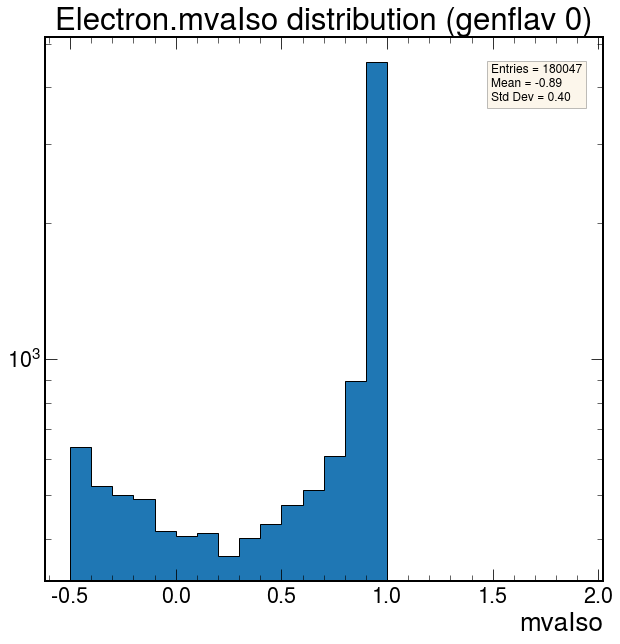

In [13]:
fig, ax = plt.subplots()
ax.set_xlabel("mvaIso")
ax.set_title("Electron.mvaIso distribution (genflav 0)")
ax.set_yscale('log')
flattened_mva = ak.flatten(flav0_e.mvaIso)

#_____________________________
#stats box to imitate root's:
mean = np.mean(flattened_mva)
std_dev = np.std(flattened_mva)
entries = len(flattened_mva)
stats_text = f"Entries = {entries}\nMean = {mean:.2f}\nStd Dev = {std_dev:.2f}"
props = dict(boxstyle='square', facecolor='wheat', alpha=0.25)
ax.text(0.80, 0.95, stats_text, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)
#end stats box code
#-----------------------------


bin_edges = np.arange(-0.5, 2, 0.1)

#ax.hist(filtered_counts, bins=np.linspace(0, 5, 6))  # bins from 1 to 4
ax.hist(flattened_mva, bins=bin_edges, histtype='stepfilled', edgecolor='black')
plt.show()

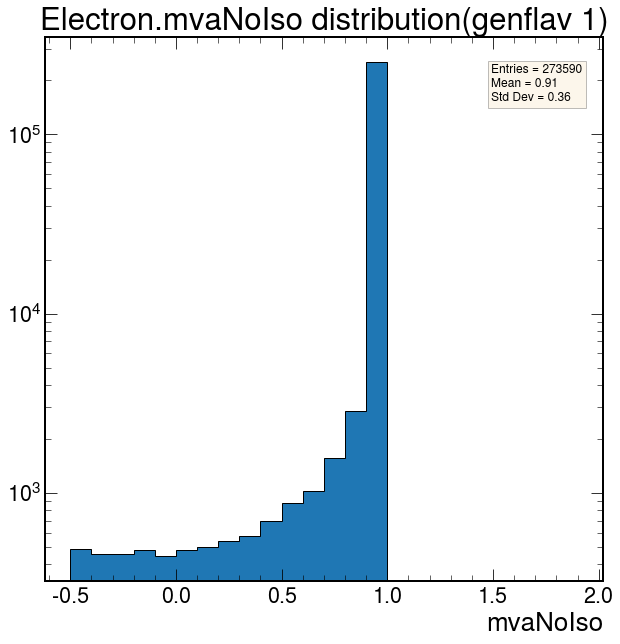

In [14]:
fig, ax = plt.subplots()
ax.set_xlabel("mvaNoIso")
ax.set_title("Electron.mvaNoIso distribution(genflav 1)")
ax.set_yscale('log')
flattened_mvaNoIso = ak.flatten(flav1_e.mvaNoIso)

#_____________________________
#stats box to imitate root's:
mean = np.mean(flattened_mvaNoIso)
std_dev = np.std(flattened_mvaNoIso)
entries = len(flattened_mvaNoIso)
stats_text = f"Entries = {entries}\nMean = {mean:.2f}\nStd Dev = {std_dev:.2f}"
props = dict(boxstyle='square', facecolor='wheat', alpha=0.25)
ax.text(0.80, 0.95, stats_text, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)
#end stats box code
#-----------------------------


bin_edges = np.arange(-0.5, 2, 0.1)

#ax.hist(filtered_counts, bins=np.linspace(0, 5, 6))  # bins from 1 to 4
ax.hist(flattened_mvaNoIso, bins=bin_edges, histtype='stepfilled', edgecolor='black')
plt.show()

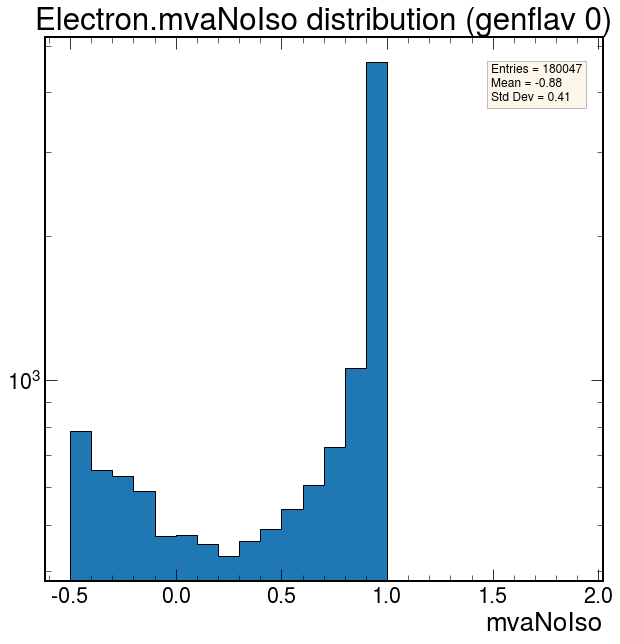

In [15]:
fig, ax = plt.subplots()
ax.set_xlabel("mvaNoIso")
ax.set_title("Electron.mvaNoIso distribution (genflav 0)")
ax.set_yscale('log')
flattened_mvaNoIso = ak.flatten(flav0_e.mvaNoIso)

#_____________________________
#stats box to imitate root's:
mean = np.mean(flattened_mvaNoIso)
std_dev = np.std(flattened_mvaNoIso)
entries = len(flattened_mvaNoIso)
stats_text = f"Entries = {entries}\nMean = {mean:.2f}\nStd Dev = {std_dev:.2f}"
props = dict(boxstyle='square', facecolor='wheat', alpha=0.25)
ax.text(0.80, 0.95, stats_text, transform=ax.transAxes, fontsize=12, verticalalignment='top', bbox=props)
#end stats box code
#-----------------------------


bin_edges = np.arange(-0.5, 2, 0.1)

#ax.hist(filtered_counts, bins=np.linspace(0, 5, 6))  # bins from 1 to 4
ax.hist(flattened_mvaNoIso, bins=bin_edges, histtype='stepfilled', edgecolor='black')
plt.show()